In [56]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

In [57]:
def age_to_days(input_string):
    # Define regular expressions to match years and days
    years_regex = r'(\d+)\s*years?'
    days_regex = r'(\d+)\s*days?'

    # Search for years and days in the input string
    years_match = re.search(years_regex, input_string)
    days_match = re.search(days_regex, input_string)

    # Initialize variables to store years and days
    years = 0
    days = 0

    if years_match:
        years = int(years_match.group(1))
    if days_match:
        days = int(days_match.group(1))

    if years == 0 and days == 0:
        return np.nan

    total = years * 365 + days

    return total

In [58]:
def days_to_age(total_days):
    # Calculate the number of years
    years = total_days // 365

    # Calculate the remaining days
    days = total_days % 365

    # Format the age string
    age_string = f"{years} years {days} days"

    return age_string


In [59]:
mutatations = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

# To make the data more readable, we will replace the 'MUTATED' and 'NOT_MUTATED' values with True and False
mutatations.replace('MUTATED', True, inplace=True)
mutatations.replace('NOT_MUTATED', False, inplace=True)

# Along with the 'MUTATED' and 'NOT_MUTATED' values, we will also found that Grade and Project are redundant columns so we will drop the project column
mutatations.drop(columns=['Project'], inplace=True)

# We will also drop the Case_ID column as it is not useful for our analysis
mutatations.drop(columns=['Case_ID'], inplace=True)

# Interpret the age_at_diagnosis column as a int to be able to perform calculations
mutatations['Age_at_diagnosis'] = mutatations['Age_at_diagnosis'].apply(age_to_days)

mutatations.describe()
mutatations

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\1243639016.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mutatations.replace('NOT_MUTATED', False, inplace=True)


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,18723.0,"Oligodendroglioma, NOS",white,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,LGG,Male,14131.0,Mixed glioma,white,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,LGG,Male,12837.0,"Astrocytoma, NOS",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,LGG,Female,11963.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,LGG,Male,11502.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,28430.0,Glioblastoma,white,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
858,GBM,Male,31090.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
859,GBM,Female,28283.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
860,GBM,Male,23116.0,Glioblastoma,white,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [60]:
# By analysing the data, we found that some information was marked as "--" and we decided to replace it with NaN for better analysis
mutatations.replace('--', np.nan, inplace=True)

missing = mutatations.loc[mutatations["Gender"].isnull() & mutatations["Age_at_diagnosis"].isnull() & mutatations["Primary_Diagnosis"].isnull() & mutatations["Race"].isnull()]
print(missing)
print("Missing:", len(missing))
# We found that there were 4 rows null in each of the columns, so we decided to remove them from the data because filling them with the mean or median would not be accurate because the data is categorical
# and we would be filling them possibilites with the same value and completly different mutation data
mutatations.drop(index=missing.index, inplace=True)

# We will now fill the missing values in the 'Age_at_diagnosis' column with the median value for the specific row that has only that field missing
missing_only_age = mutatations.loc[mutatations["Age_at_diagnosis"].isnull()]

# To fill the missing data more accurately, we will group the data by 'Grade', 'Gender', 'Primary_Diagnosis' and 'Race' and calculate the mean of the 'Age_at_diagnosis' column
grouped_data = mutatations.groupby(['Grade', 'Gender', 'Primary_Diagnosis', 'Race'])['Age_at_diagnosis'].mean()


    Grade Gender  Age_at_diagnosis Primary_Diagnosis Race   IDH1   TP53  \
41    LGG    NaN               NaN               NaN  NaN   True   True   
671   GBM    NaN               NaN               NaN  NaN  False  False   
706   GBM    NaN               NaN               NaN  NaN  False  False   
794   GBM    NaN               NaN               NaN  NaN  False  False   

      ATRX   PTEN   EGFR  ...  FUBP1    RB1  NOTCH1   BCOR  CSMD3  SMARCA4  \
41    True  False  False  ...  False  False   False  False  False    False   
671  False  False  False  ...  False  False   False  False  False    False   
706  False   True  False  ...  False  False   False  False  False    False   
794  False  False   True  ...  False  False   False  False  False    False   

     GRIN2A   IDH2   FAT4  PDGFRA  
41    False  False  False   False  
671   False  False  False   False  
706   False  False  False   False  
794   False  False  False   False  

[4 rows x 25 columns]
Missing: 4


In [61]:
grouped_data = grouped_data.to_frame().reset_index()
for idx, row in missing_only_age.iterrows():
    matched_rows = grouped_data.loc[(grouped_data["Grade"] == row["Grade"]) &
                                    (grouped_data["Gender"] == row["Gender"]) &
                                    (grouped_data["Primary_Diagnosis"] == row["Primary_Diagnosis"]) &
                                    (grouped_data["Race"] == row["Race"])]

In [62]:
missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])
mutatations.update(missing_only_age)
mutatations

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\3960743357.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\3960743357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,18723.0,"Oligodendroglioma, NOS",white,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,LGG,Male,14131.0,Mixed glioma,white,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,LGG,Male,12837.0,"Astrocytoma, NOS",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,LGG,Female,11963.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,LGG,Male,11502.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,28430.0,Glioblastoma,white,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
858,GBM,Male,31090.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
859,GBM,Female,28283.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
860,GBM,Male,23116.0,Glioblastoma,white,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


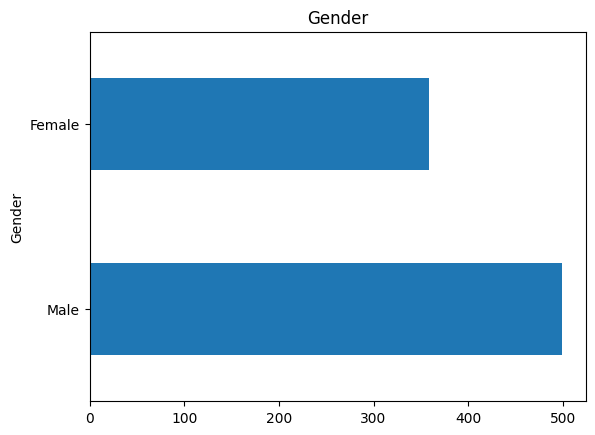

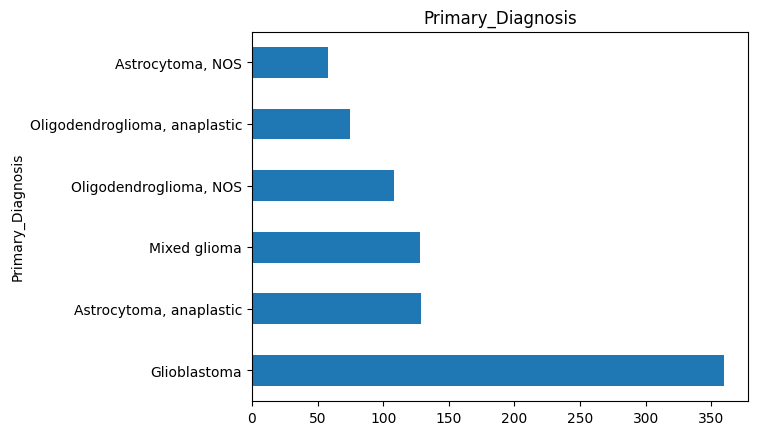

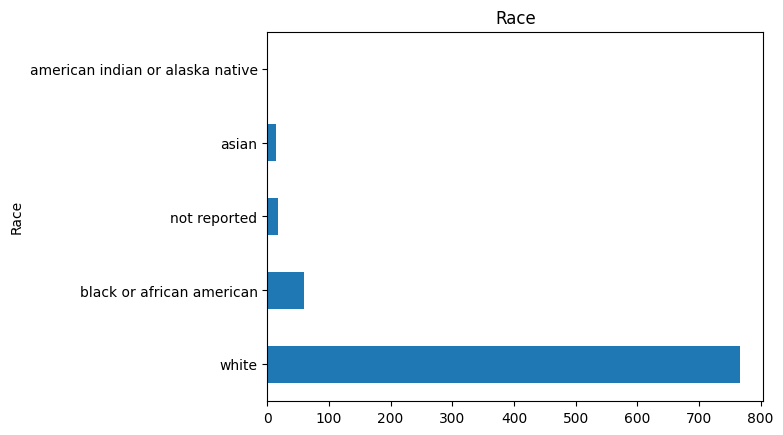

In [63]:
selected_columns = ["Gender", "Primary_Diagnosis", "Race"]

for column in selected_columns:
    column_counts = mutatations[column].value_counts()
    column_counts.plot(kind='barh')
    plt.title(column)
    plt.show()


In [64]:
# As we can see from the pie graph there are some values that are not reported, we will now fill them with the most common value for the specific row
not_reported_race = mutatations.loc[mutatations["Race"] == "not reported"]

for idx, row in not_reported_race.iterrows():
    most_common_race = mutatations.loc[(mutatations["Grade"] == row["Grade"]) &
                                   (mutatations["Gender"] == row["Gender"]) &
                                   (mutatations["Primary_Diagnosis"] == row["Primary_Diagnosis"])]["Race"].value_counts().idxmax()
    not_reported_race["Race"] = most_common_race
mutatations.update(not_reported_race)
mutatations

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\3826644425.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_reported_race["Race"] = most_common_race
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\3826644425.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_reported_race["Race"] = most_common_race
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_10344\3826644425.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,18723.0,"Oligodendroglioma, NOS",white,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,LGG,Male,14131.0,Mixed glioma,white,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,LGG,Male,12837.0,"Astrocytoma, NOS",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,LGG,Female,11963.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,LGG,Male,11502.0,"Astrocytoma, anaplastic",white,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,28430.0,Glioblastoma,white,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
858,GBM,Male,31090.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
859,GBM,Female,28283.0,Glioblastoma,white,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
860,GBM,Male,23116.0,Glioblastoma,white,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


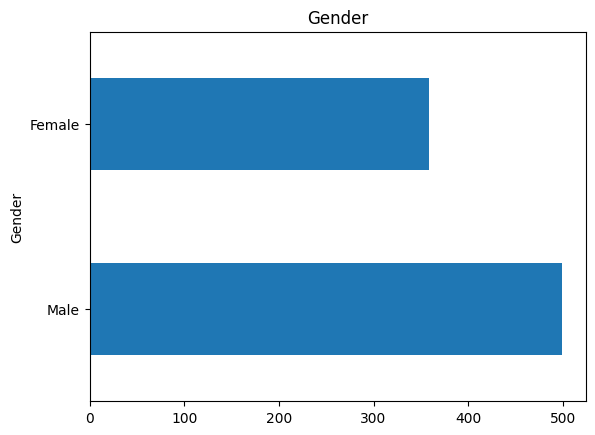

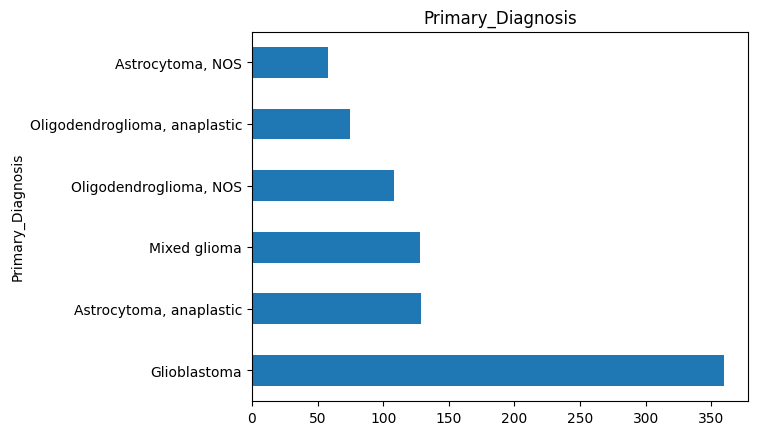

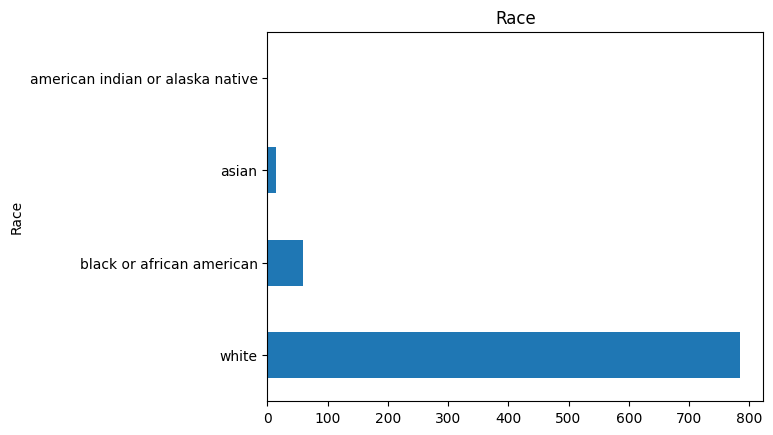

In [65]:
# As we can see now we have a much cleaner dataset with no missing values that is ready for further analysis

selected_columns = ["Gender", "Primary_Diagnosis", "Race"]

for column in selected_columns:
    column_counts = mutatations[column].value_counts()
    column_counts.plot(kind='barh')
    plt.title(column)
    plt.show()


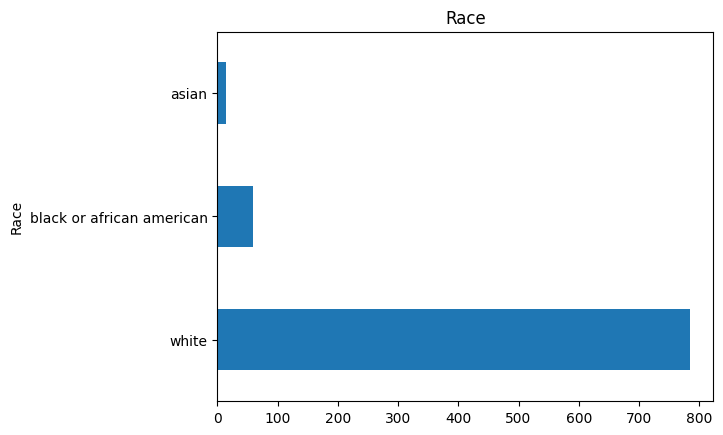

In [66]:
# As we can see there is a very small number of 'american indian or alaska native' values, so we decided to remove them from the dataset
mutatations.drop(index=mutatations[mutatations["Race"] == "american indian or alaska native"].index, inplace=True)
column_counts = mutatations["Race"].value_counts()
column_counts.plot(kind='barh')
plt.title("Race")
plt.show()

In [67]:
mutatations.to_csv('TCGA_GBM_LGG_Mutations_clean.csv', index=False)